<h2><b> Connecting to Kaggle </b></h2>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# # Importing the 'files' module from Google Colab which allows file operations in Colab
# from google.colab import files
# files.upload()

In [3]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

<h2><b> Downloading the Dataset </b></h2>

In [4]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 427M/428M [00:11<00:00, 44.4MB/s]
100% 428M/428M [00:11<00:00, 39.9MB/s]


<h2><b> Unzipping the Dataset </b></h2>

In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/toronto-emotional-speech-set-tess.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

<h2><b> Importing the Modules </b></h2>

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

<h2><b> Loading the Audio Files </b></h2>

In [7]:
# An empty list to store file paths
paths = []

# An empty list to store labels corresponding to the file paths
labels = []

In [8]:
import os
path = r'/content/TESS Toronto emotional speech set data'
base_dir = path

In [9]:
# Loop through the directory tree starting from 'base_dir'

for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:

        # Append the path and filename to the 'paths' list
        paths.append(os.path.join(dirname, filename))

        # Extract the label from the filename by splitting it by the '_' character
        # The label is assumed to be the last part after the underscore
        label = filename.split('_')[-1]

        # Further split the label by the '.' to remove the file extension and get the raw label
        label = label.split('.')[0]

         # Convert the label to lowercase for consistency and append it to the 'labels' list
        labels.append(label.lower())

In [10]:
len(paths)

2800

<Axes: xlabel='label', ylabel='count'>

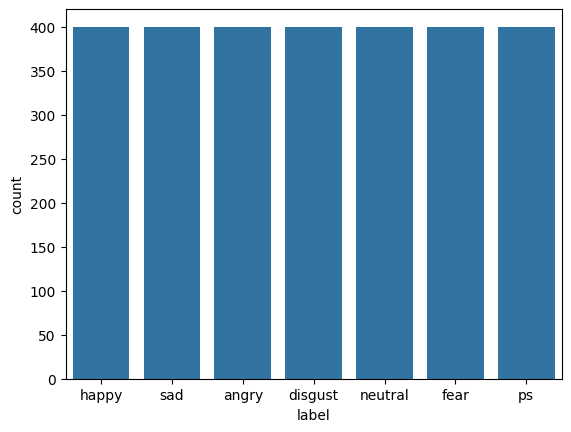

In [11]:
# Create an empty DataFrame
df = pd.DataFrame()

# Add a 'speech' column to the DataFrame containing file paths
df['speech'] = paths

# Add a 'label' column to the DataFrame containing the corresponding labels
df['label'] = labels

sns.countplot(data=df, x='label')

In [12]:
paths[:25]

['/content/TESS Toronto emotional speech set data/OAF_happy/OAF_seize_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_mop_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_back_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_kite_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_talk_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_book_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_voice_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_sail_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_cool_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_haze_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_wag_happy.wav',
 '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_five_happy.wav',
 '/content/TESS Toronto emot

In [13]:
labels[:25]

['happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy']

In [14]:
df['speech']

,speech
0,/content/TESS Toronto emotional speech set dat...
1,/content/TESS Toronto emotional speech set dat...
2,/content/TESS Toronto emotional speech set dat...
3,/content/TESS Toronto emotional speech set dat...
4,/content/TESS Toronto emotional speech set dat...
...,...
2795,/content/TESS Toronto emotional speech set dat...
2796,/content/TESS Toronto emotional speech set dat...
2797,/content/TESS Toronto emotional speech set dat...
2798,/content/TESS Toronto emotional speech set dat...


In [15]:
df['label']

,label
0,happy
1,happy
2,happy
3,happy
4,happy
...,...
2795,neutral
2796,neutral
2797,neutral
2798,neutral


<h2><b> Exploratory Data Analysis </b></h2>

In [16]:
# Function to plot the waveform of an audio signal
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4)) # Create a new figure with a specified size
    plt.title(emotion, size=20) # Set the title of the plot to the specified emotion
    librosa.display.waveshow(data, sr=sr) # Display the waveform of the audio data
    plt.show()

# Function to plot the spectrogram of an audio signal
def spectogram(data, sr, emotion):
    x = librosa.stft(data) # Compute the Short-Time Fourier Transform
    xdb = librosa.amplitude_to_db(abs(x)) # Convert the amplitude to decibels (dB)
    plt.figure(figsize=(11,4))   # Create a new figure with a specified size
    plt.title(emotion, size=20) # Set the title of the plot
    # Display the spectrogram using librosa's specshow function
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

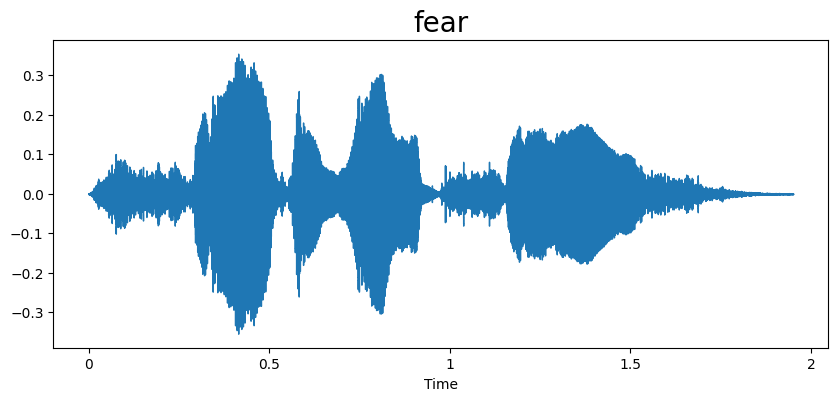

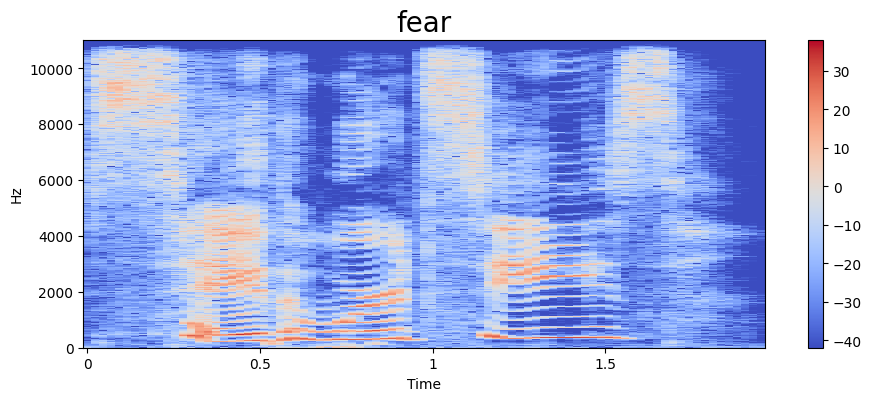

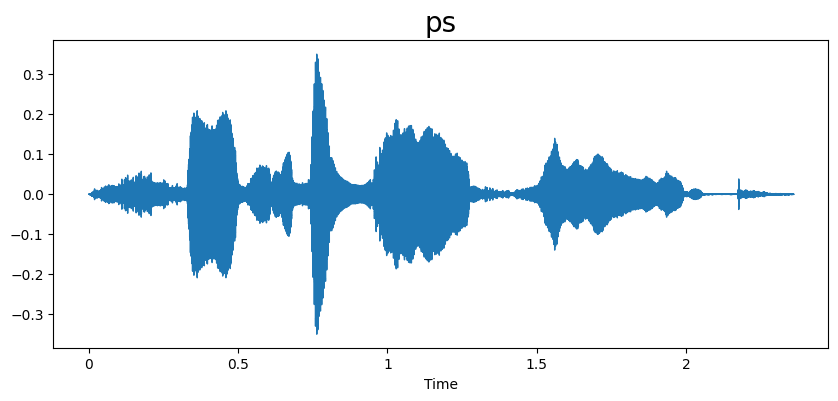

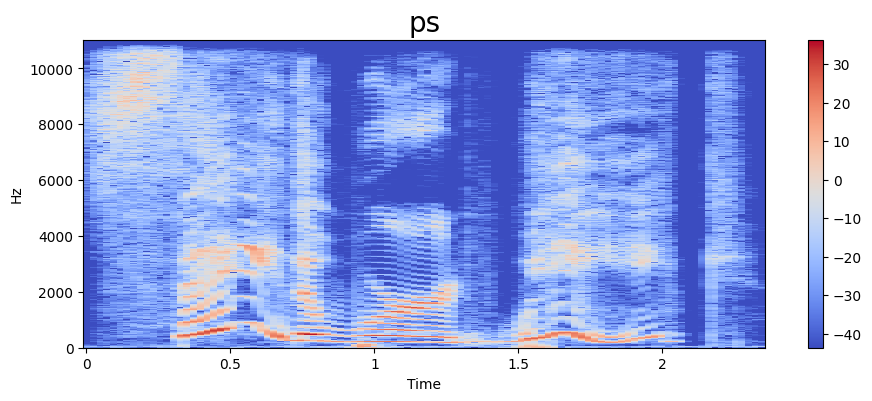

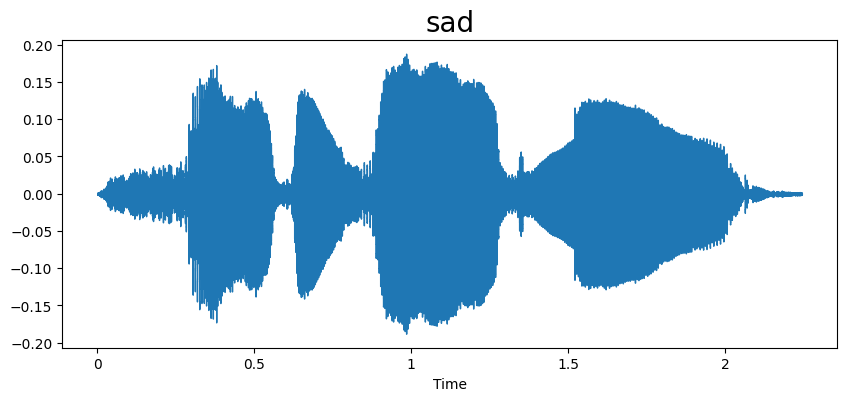

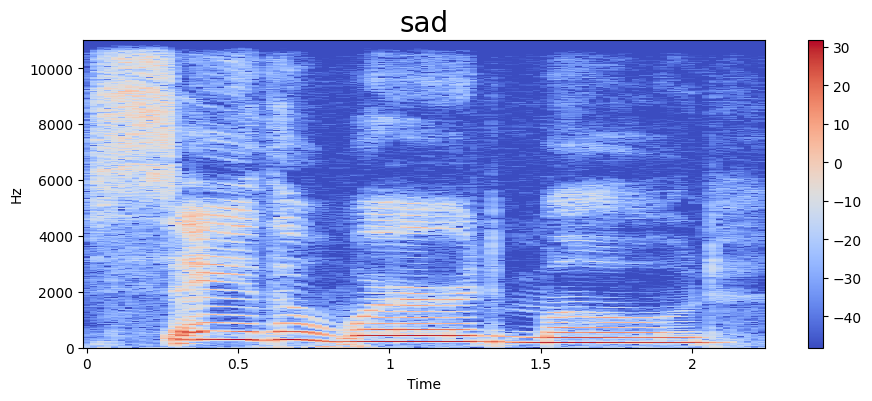

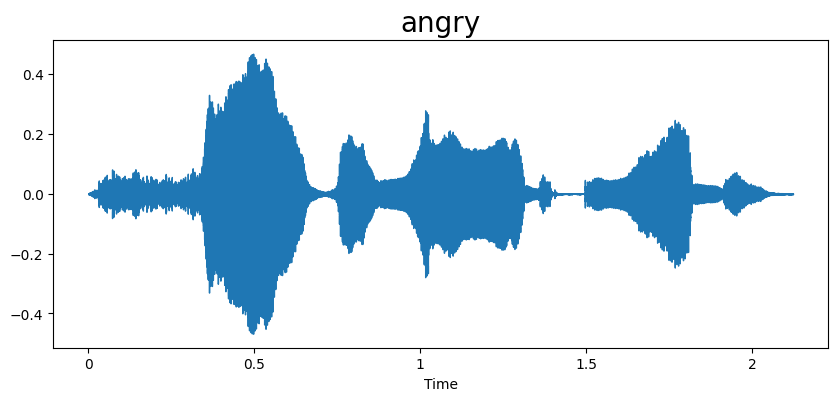

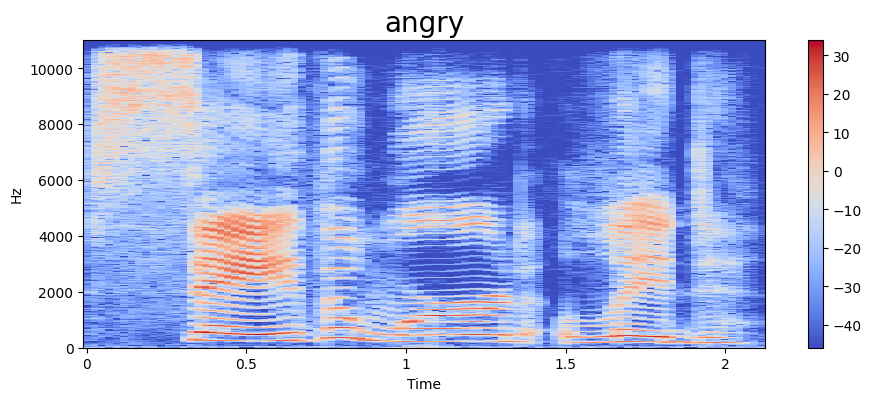

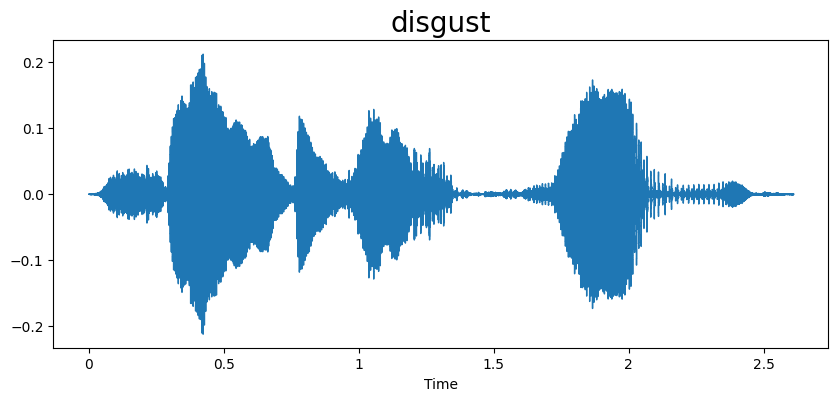

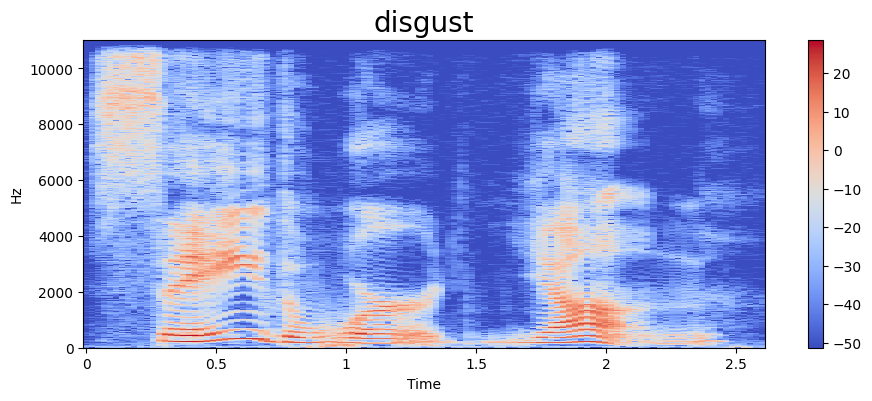

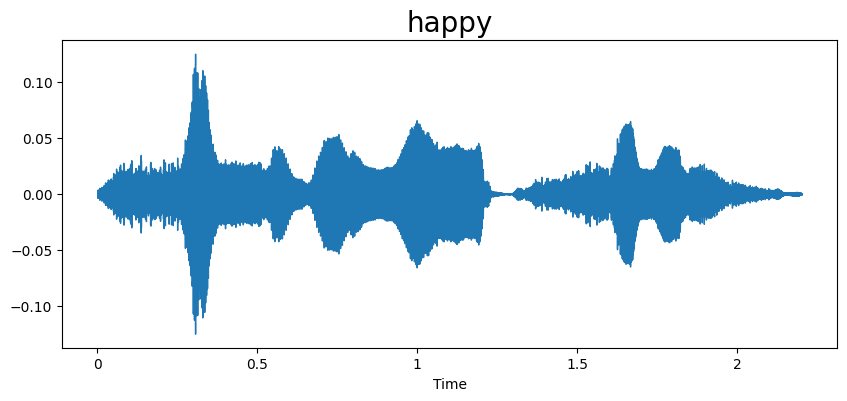

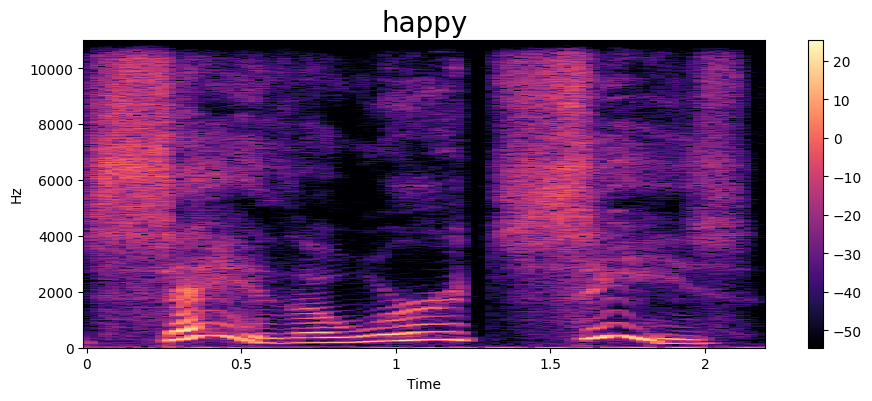

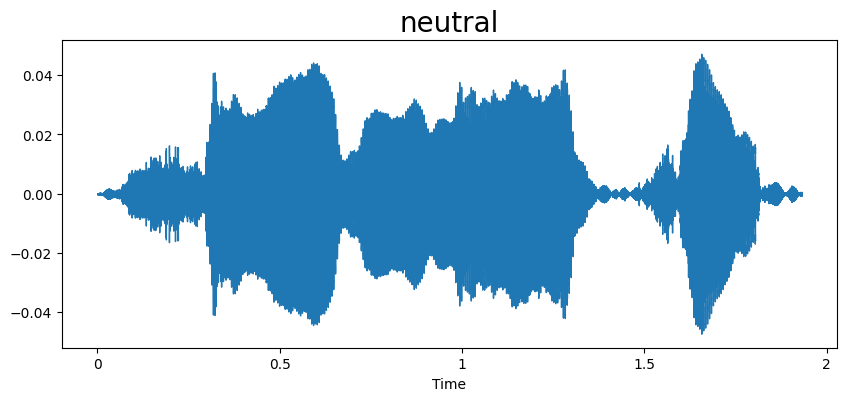

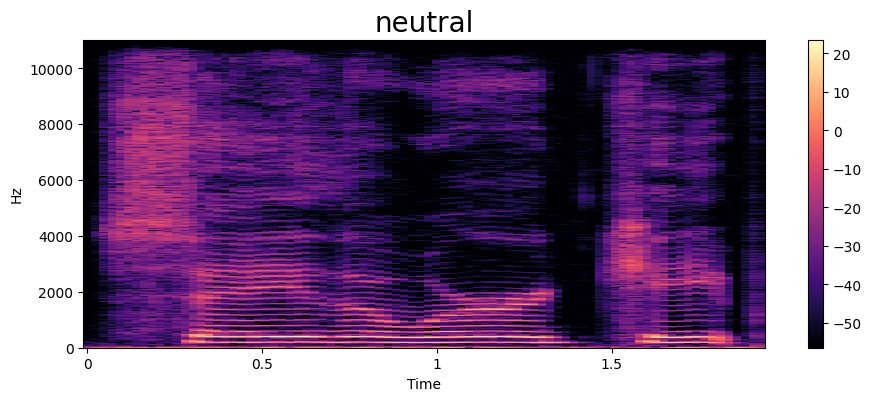

In [17]:
# Loop through each emotion in the emotions list
emotions = ['fear', 'ps', 'sad', 'angry', 'disgust', 'happy', 'neutral']

# Loop through each emotion in the emotions list
for emotion in emotions:
    # Get the first file path corresponding to the current emotion
    path = np.array(df['speech'][df['label']==emotion])[0]
    # Load the audio file from the specified path using librosa
    data, sampling_rate = librosa.load(path)
    # Call the waveplot function to visualize the waveform
    waveplot(data, sampling_rate, emotion)
    # Call the spectogram function to visualize the spectrogram
    spectogram(data, sampling_rate, emotion)

<h2><b> MFCC Feature Extraction </b></h2>

In [18]:
# Function to extract MFCC features
def extract_mfcc(filename):
    # Load the audio file with librosa
    # 'duration' specifies the length of the audio clip to load (in seconds)
    # 'offset' specifies the start time to load the audio
    y, sr = librosa.load(filename, duration=3, offset=0.5)

    # Extract MFCC features from the audio data
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=60).T, axis=0)

    return mfcc

# Apply the extract_mfcc function to each audio file path in the 'speech' column of the DataFrame
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [19]:
X_mfcc

,speech
0,"[-473.3913, 47.294632, 28.475006, 12.212405, 3..."
1,"[-460.7585, 113.900536, 23.663628, -13.877025,..."
2,"[-493.50653, 108.03115, 13.071025, -14.596373,..."
3,"[-469.49454, 89.08621, 10.975073, -2.1457024, ..."
4,"[-484.0466, 93.0804, 13.643845, -8.042135, 3.5..."
...,...
2795,"[-467.44693, 88.579094, 0.32247487, 14.485661,..."
2796,"[-443.4918, 135.16476, 26.464458, 20.139612, -..."
2797,"[-425.44254, 77.5451, 3.2355874, 31.164782, 1...."
2798,"[-455.54843, 94.78655, 5.982284, 20.885273, -5..."


In [20]:
# Convert the Series of MFCC features (X_mfcc) into a list
X = [x for x in X_mfcc]

# Convert the list of MFCC features into a NumPy array
X = np.array(X)

X

array([[-4.73391296e+02,  4.72946320e+01,  2.84750061e+01, ...,
         2.52049208e+00, -3.77966493e-01,  2.75498819e+00],
       [-4.60758514e+02,  1.13900536e+02,  2.36636276e+01, ...,
        -6.54848814e-01,  1.96990442e+00,  1.38237381e+00],
       [-4.93506531e+02,  1.08031151e+02,  1.30710249e+01, ...,
        -1.41915464e+00, -9.95611787e-01, -7.04604864e-01],
       ...,
       [-4.25442535e+02,  7.75450974e+01,  3.23558736e+00, ...,
        -1.38646030e+00, -7.22239828e+00, -1.24009109e+00],
       [-4.55548431e+02,  9.47865524e+01,  5.98228407e+00, ...,
         1.68654025e+00, -2.81883001e+00, -2.45457244e+00],
       [-4.30682281e+02,  6.40563812e+01,  4.90539455e+00, ...,
         4.83183765e+00,  4.68930185e-01, -2.04417014e+00]], dtype=float32)

In [21]:
# Expand the dimensions of the NumPy array X to add an additional axis at the end
X = np.expand_dims(X, -1)
X

array([[[-4.73391296e+02],
        [ 4.72946320e+01],
        [ 2.84750061e+01],
        ...,
        [ 2.52049208e+00],
        [-3.77966493e-01],
        [ 2.75498819e+00]],

       [[-4.60758514e+02],
        [ 1.13900536e+02],
        [ 2.36636276e+01],
        ...,
        [-6.54848814e-01],
        [ 1.96990442e+00],
        [ 1.38237381e+00]],

       [[-4.93506531e+02],
        [ 1.08031151e+02],
        [ 1.30710249e+01],
        ...,
        [-1.41915464e+00],
        [-9.95611787e-01],
        [-7.04604864e-01]],

       ...,

       [[-4.25442535e+02],
        [ 7.75450974e+01],
        [ 3.23558736e+00],
        ...,
        [-1.38646030e+00],
        [-7.22239828e+00],
        [-1.24009109e+00]],

       [[-4.55548431e+02],
        [ 9.47865524e+01],
        [ 5.98228407e+00],
        ...,
        [ 1.68654025e+00],
        [-2.81883001e+00],
        [-2.45457244e+00]],

       [[-4.30682281e+02],
        [ 6.40563812e+01],
        [ 4.90539455e+00],
        ...,
        

In [22]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
enc = OneHotEncoder()

# Apply OneHotEncoder to the 'label' column of the DataFrame
# The fit_transform method fits the encoder to the data and then transforms it into a one-hot encoded format
y = enc.fit_transform(df[['label']])
y

<2800x7 sparse matrix of type '<class 'numpy.float64'>'
	with 2800 stored elements in Compressed Sparse Row format>

In [23]:
# Convert the sparse matrix of one-hot encoded labels to a dense NumPy array
y = y.toarray()
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

<h2><b> Creating Train and Test Dataset </b></h2>

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# Split the dataset into training and testing sets
# X contains the features (MFCCs), y contains the one-hot encoded labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (2240, 60, 1), Training labels shape: (2240, 7)
Testing data shape: (560, 60, 1), Testing labels shape: (560, 7)


<h2><b>Neural Architecture Search</b></h2>

<h2><b>1. LSTM Model </b></h2>

In [26]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.3 MB/s eta 0:00:00


In [27]:
import tensorflow as tf
from keras import layers, models
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

In [28]:
# Define a model-building function with LSTM layers only
class AudioModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(layers.Input(shape=X_train.shape[1:]))  # Assuming X_train shape is (60, 1)

        # Add LSTM layers with tunable parameters
        for i in range(hp.Int('num_lstm_layers', 1, 3)):  # Tuning number of LSTM layers
            model.add(layers.LSTM(
                units=hp.Int(f'lstm_units_{i}', 32, 128, step=32),
                return_sequences=(i < hp.Int('num_lstm_layers', 1, 3) - 1)  # Only last layer should not return sequences
            ))
            model.add(layers.Dropout(0.2))  # Adding dropout for regularization

        model.add(layers.Flatten())  # Flatten before dense layers

        # Dense layers with tunable units
        for j in range(hp.Int('num_dense_layers', 1, 3)):  # Tuning number of dense layers
            model.add(layers.Dense(
                units=hp.Int(f'units_{j}', 32, 128, step=16),
                activation='relu'
            ))
            model.add(layers.Dropout(0.2))  # Adding dropout for regularization

        # Output layer with softmax activation
        model.add(layers.Dense(y_train.shape[1], activation='softmax'))

        # Compile model with a hyperparameter-tuned optimizer
        model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

# Set up the Keras Tuner
tuner = RandomSearch(
    AudioModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='audio_tuner',
    project_name='audio_recognition'
)

# Perform the search
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 33s]
val_accuracy: 0.9479166666666666

Best val_accuracy So Far: 0.9717261791229248
Total elapsed time: 00h 05m 37s


In [29]:
print("\nBest Model Architecture:")
print("Optimizer details:", best_model.optimizer)
best_model.summary()



Best Model Architecture:
Optimizer details: <keras.src.optimizers.rmsprop.RMSprop object at 0x78d2b1b43d90>


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 96)              │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         115,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │           6,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,367 (622.53 KB)

 Trainable params: 159,367 (622.53 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.6f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9653 - loss: 0.1146
Test accuracy: 95.357144


<h2><b> Model <b></h2>

<h3><b> 1. Transformer Model </b></h3>

<h4><b>Create Custom Dataset Class</b></h4>

In [31]:
df_tf = df

In [32]:
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df_tf['label'] = df['label'].map(label_map)
df_tf.head(2)

,speech,label
0,/content/TESS Toronto emotional speech set dat...,0
1,/content/TESS Toronto emotional speech set dat...,0


In [33]:
len(df_tf)

2800

In [34]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df_tf, processor, max_length=32000):
        self.df_tf = df_tf
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df_tf)

    def __getitem__(self, idx):
        audio_path = self.df_tf.iloc[idx]['speech']
        label = self.df_tf.iloc[idx]['label']

        # load the audio file
        speech, sr = librosa.load(audio_path, sr=16000)

        # pad or turncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # preprocess the audio file
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)

        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

In [35]:
from sklearn.model_selection import train_test_split
train_tf, test_tf = train_test_split(df_tf, test_size=0.2, random_state=42)

In [36]:
print("train_tf.shape", train_tf.shape)
print("test_tf.shape", test_tf.shape)

train_tf.shape (2240, 2)
test_tf.shape (560, 2)


In [37]:
# initiate the processor and model
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
tf_model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)



preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# load the Dataset
train_dataset = SpeechEmotionDataset(train_tf, processor)
test_dataset = SpeechEmotionDataset(test_tf, processor)

In [39]:
train_dataset[0]['input_values'].size()

Keyword argument `truncate` is not a valid argument for this processor and will be ignored.


torch.Size([32000])

In [40]:
# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

<h2><b>Set Training Parameter</b></h2>

In [41]:
training_args = TrainingArguments(
    output_dir='content/results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)

In [42]:
# create functions for computing matics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids # origin labels
    preds = np.argmax(pred.predictions, axis=1) # model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [43]:
# initialize the trainer
trainer = Trainer(
    model=tf_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.507317,0.998214,0.998234,0.998214,0.998214
2,No log,0.187151,1.000000,1.000000,1.000000,1.000000
3,No log,0.143138,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=420, training_loss=0.6117133730933779, metrics={'train_runtime': 386.0122, 'train_samples_per_second': 17.409, 'train_steps_per_second': 1.088, 'total_flos': 1.2201848064e+17, 'train_loss': 0.6117133730933779, 'epoch': 3.0})

In [44]:
result = trainer.evaluate()
print(result)

{'eval_loss': 0.1431378275156021, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 6.1354, 'eval_samples_per_second': 91.274, 'eval_steps_per_second': 5.705, 'epoch': 3.0}


In [45]:
result

{'eval_loss': 0.1431378275156021,
 'eval_accuracy': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_f1': 1.0,
 'eval_runtime': 6.1354,
 'eval_samples_per_second': 91.274,
 'eval_steps_per_second': 5.705,
 'epoch': 3.0}

In [46]:
import random
idx = random.randrange(0, len(test_dataset))

# Retrieve and print the original label
original_label = test_dataset[idx]['labels']
print('Original Label:', inverse_label_map[int(original_label)])

# Retrieve input values, unsqueeze, and move to GPU
input_values = test_dataset[idx]['input_values'].unsqueeze(0).cuda()

# Perform inference
with torch.no_grad():
    outputs = tf_model(input_values)
    logits = outputs.logits

# Get the predicted class
predicted_class = logits.argmax(dim=-1).item()
print('Predicted Label:', inverse_label_map[predicted_class])

Original Label: angry
Predicted Label: angry


In [47]:
processor.save_pretrained('./wav2vec2_model')
tf_model.save_pretrained('./wav2vec2_model')

In [48]:
# from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor

# # Path to save the model
# model_save_path = "./wave2vec_model"


# # Save the model and feature extractor
# tf_model.save_pretrained(model_save_path)  # Saves model weights and config.json
# feature_extractor.save_pretrained(model_save_path)  # Saves preprocessor_config.json

# print(f"Model and feature extractor saved to {model_save_path}")



In [49]:
# import shutil

# # Zip the folder
# shutil.make_archive('wave2vec_model', 'zip', './wave2vec_model')

# print("Model folder zipped successfully.")
# from google.colab import files

# # Download the zip file
# files.download('wave2vec_model.zip')


<h3><b> 2. LSTM (256) <b></h3>

In [50]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, mean_squared_error
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, Embedding, Flatten

In [51]:
# Define the teacher model using Sequential API
lstm_256_teacher_model = Sequential([

    # First LSTM layer with 256 units, return_sequences=False since it's the last LSTM layer
    # Input shape is (60, 1) where 60 is the number of time steps and 1 is the feature per time step
    LSTM(256, return_sequences=False, input_shape=(60, 1)),

    Dropout(0.2), # Prevent Overfitting

    # Dense layer with 128 units and ReLU activation
    Dense(128, activation='relu'),

    Dropout(0.2), # Prevent Overfitting

    # Dense layer with 64 units and ReLU activation
    Dense(64, activation='relu'),
    Dropout(0.2), # Prevent Overfitting

     # Output layer with 7 units (corresponding to the number of classes), using softmax activation
    Dense(7, activation='softmax') # Softmax is used for multiclass classification
])

In [52]:
# Compile the teacher model
lstm_256_teacher_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the teacher model
lstm_256_teacher_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

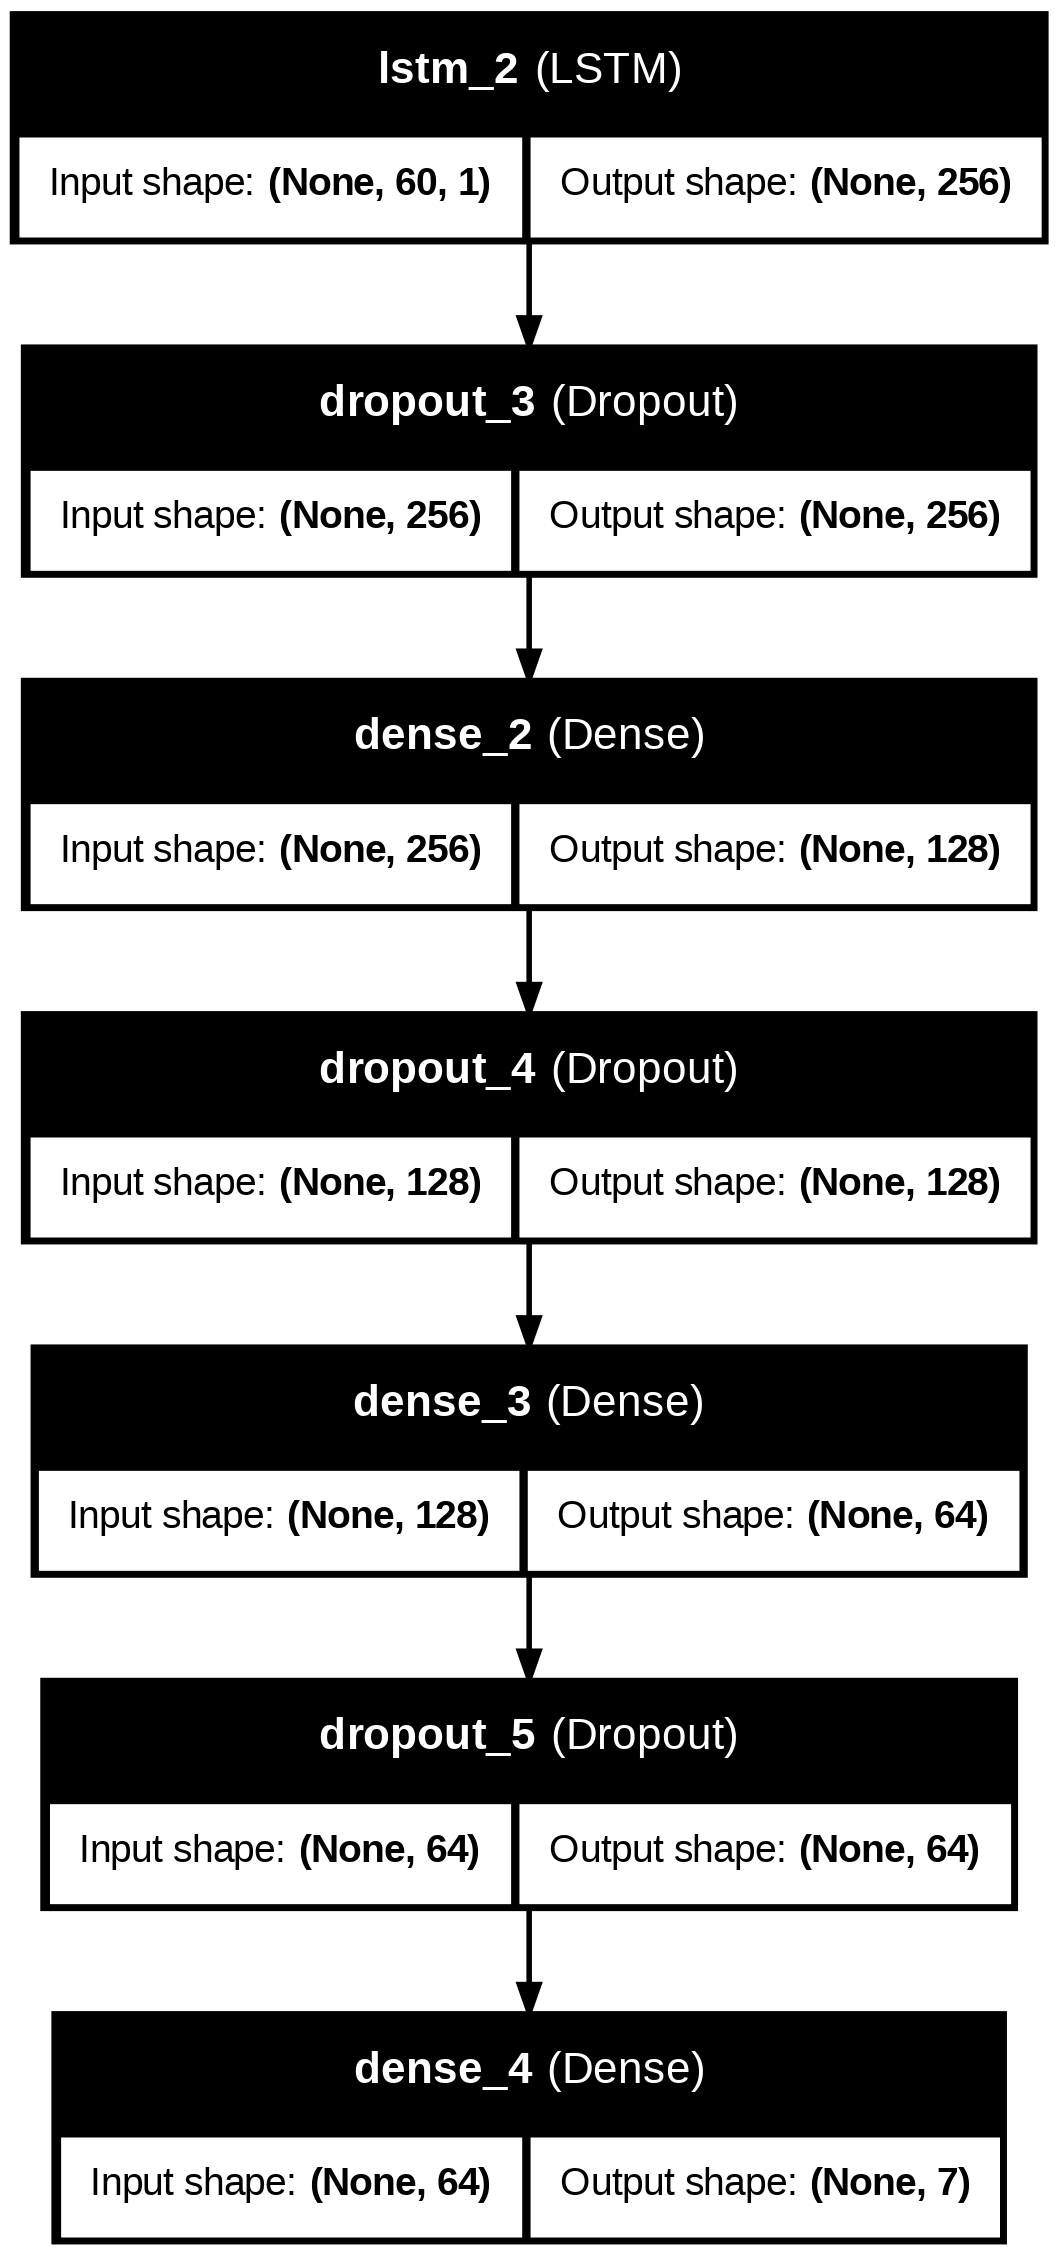

In [53]:
from tensorflow.keras.utils import plot_model

# Print the architecture of the model
lstm_256_teacher_model.summary()

# Optionally save a visual representation of the architecture
plot_model(
    lstm_256_teacher_model,
    to_file="teacher_model_architecture.png",
    show_shapes=True,
    show_layer_names=True
)

In [54]:

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Track validation loss
    patience=5,             # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

lstm_256_teacher_history = lstm_256_teacher_model.fit(
    X_train,  # The input training data (MFCC features)
    y_train,  # The one-hot encoded labels for the training data
    validation_split=0.2, # Use 20% of the training data as validation set
    epochs=50, # Train the model for 50 epochs
    batch_size=64, # Use mini-batches of size 64 for each training step
    callbacks=[early_stopping]     # Include early stopping callback
)

# Check how many epochs were run
print(f"Model trained for {len(lstm_256_teacher_history.epoch)} epochs.")

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2561 - loss: 1.7964 - val_accuracy: 0.6585 - val_loss: 0.8428
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6444 - loss: 0.8490 - val_accuracy: 0.7835 - val_loss: 0.5448
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7629 - loss: 0.5777 - val_accuracy: 0.7902 - val_loss: 0.5627
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7961 - loss: 0.5132 - val_accuracy: 0.8973 - val_loss: 0.3470
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8853 - loss: 0.3485 - val_accuracy: 0.8973 - val_loss: 0.3079
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9159 - loss: 0.2749 - val_accuracy: 0.8728 - val_loss: 0.4480
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8996 - loss: 0.3683 - val_accuracy: 0.9174 - val_loss: 0.2738
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9392 - loss: 0.2165 - val_accuracy: 0.9487 - val_lo

In [55]:
# lstm_256_teacher_model.save('/content/drive/MyDrive/Sentiment_Analysis/lstm_256_teacher_lstm.hdf5')

<h3><b>3. LSTM Model (128)</b></h3>

In [56]:
lstm_128_teacher_model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(60, 1)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

In [57]:
lstm_128_teacher_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_128_teacher_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,127 (301.28 KB)

 Trainable params: 77,127 (301.28 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Track validation loss
    patience=5,             # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

lstm_128_teacher_history = lstm_128_teacher_model.fit(
    X_train, # The input training data (MFCC features)
    y_train, # The one-hot encoded labels for the training data
    validation_split=0.2, # Use 20% of the training data as validation set
    epochs=50, # Train the model for 50 epochs
    batch_size=64, # Use mini-batches of size 64 for each training step
    callbacks=[early_stopping] # Include early stopping callback
)

# Check how many epochs were run
print(f"Model trained for {len(lstm_128_teacher_history.epoch)} epochs.")

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2122 - loss: 1.8861 - val_accuracy: 0.4018 - val_loss: 1.5274
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4120 - loss: 1.4544 - val_accuracy: 0.6719 - val_loss: 0.8952
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6225 - loss: 0.9623 - val_accuracy: 0.7946 - val_loss: 0.5655
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7519 - loss: 0.6318 - val_accuracy: 0.8817 - val_loss: 0.4051
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8254 - loss: 0.5141 - val_accuracy: 0.9018 - val_loss: 0.2989
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9001 - loss: 0.3625 - val_accuracy: 0.9129 - val_loss: 0.2672
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9245 - loss: 0.2944 - val_accuracy: 0.9576 - val_loss: 0.1628
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9208 - loss: 0.2747 - val_accuracy: 0.9129 - val_los

<h3><b> 4. GRU Model (128) </b><h3>

In [59]:
# Build the GRU model for multiclass classification
gru_model = Sequential()

# Add a GRU layer
gru_model.add(GRU(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))

# Optional Dropout layer
gru_model.add(Dropout(0.2))

# Output layer for multiclass classification (7 classes)
gru_model.add(Dense(7, activation='softmax'))

In [60]:
# Compile the model (with categorical crossentropy for multiclass classification)
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 128)                 │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,207 (200.03 KB)

 Trainable params: 51,207 (200.03 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors validation loss
    patience=5,             # Stops after 5 epochs without improvement
    restore_best_weights=True  # Restores the best model weights after stopping
)

# Train the model with early stopping
gru_history = gru_model.fit(
    X_train,  # The input training data (shape: (2240, 60, 1))
    y_train,  # The one-hot encoded labels for the training data (shape: (2240, 7))
    validation_split=0.2,  # Use 20% of the training data as validation set
    epochs=50,  # Train the model for 50 epochs
    batch_size=64,  # Use mini-batches of size 64 for each training step
    callbacks=[early_stopping]  # Include early stopping callback
)

# Check how many epochs were run
print(f"Model trained for {len(gru_history.epoch)} epochs.")

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2154 - loss: 1.8335 - val_accuracy: 0.4152 - val_loss: 1.4990
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4388 - loss: 1.4489 - val_accuracy: 0.4978 - val_loss: 1.1951
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5314 - loss: 1.1631 - val_accuracy: 0.5915 - val_loss: 1.0414
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6219 - loss: 0.9790 - val_accuracy: 0.6853 - val_loss: 0.7738
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6979 - loss: 0.7889 - val_accuracy: 0.7455 - val_loss: 0.6058
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7681 - loss: 0.6075 - val_accuracy: 0.7723 - val_loss: 0.5302
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7837 - loss: 0.5282 - val_accuracy: 0.8013 - val_loss: 0.4572
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8310 - loss: 0.4356 - val_accuracy: 0.8326 - val_loss

In [62]:
# Define the Transformer block
def transformer_block(x, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x_norm = LayerNormalization(epsilon=1e-6)(x)
    x_attn = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x_norm, x_norm)
    x = Dropout(dropout)(x_attn)
    x = x + x_norm  # Residual connection

    # Feed Forward Part
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(x.shape[-1])(x_ff)
    x = x + x_ff  # Residual connection
    return x

In [63]:
# Build the Transformer model
def build_transformer(input_shape, num_classes, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = LayerNormalization(epsilon=1e-6)(x)
    x = Flatten()(x)  # Flatten before the output layer
    x = Dense(num_classes, activation='softmax')(x)  # Output layer for multiclass classification
    return Model(inputs, x)

In [64]:
# Parameters for the Transformer model
input_shape = (60, 1)  # (time steps, features)
num_classes = 7  # Number of classes
head_size = 64  # Size of the attention heads
num_heads = 4  # Number of attention heads
ff_dim = 128  # Dimensionality of the feed forward layer
num_transformer_blocks = 2  # Number of transformer blocks
dropout = 0.2  # Dropout rate

In [65]:
# Build the model
transformer_model = build_transformer(input_shape, num_classes, head_size, num_heads, ff_dim, num_transformer_blocks, dropout)

In [66]:
# Compile the model
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
transformer_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 60, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 60, 1)          │              2 │ input_layer_4[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 60, 1)          │          1,793 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 60, 1)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 60, 1)          │              0 │ dropout_11[0][0],      │
│                           │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 60, 128)        │            256 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 60, 128)        │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 60, 1)          │            129 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 60, 1)          │              0 │ add[0][0],             │
│                           │                        │                │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 60, 1)          │              2 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 60, 1)          │          1,793 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 60, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 60, 1)          │              0 │ dropout_14[0][0],      │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 60, 128)        │            256 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 60, 128)        │              0 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)     

 Total params: 4,789 (18.71 KB)

 Trainable params: 4,789 (18.71 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors validation loss
    patience=5,             # Stops after 5 epochs without improvement
    restore_best_weights=True  # Restores the best model weights after stopping
)

# Train the model with early stopping
transformer_history = transformer_model.fit(
    X_train,  # The input training data (shape: (2240, 60, 1))
    y_train,  # The one-hot encoded labels for the training data (shape: (2240, 7))
    validation_split=0.2,  # Use 20% of the training data as validation set
    epochs=50,  # Train the model for 50 epochs
    batch_size=64,  # Use mini-batches of size 64 for each training step
    callbacks=[early_stopping]  # Include early stopping callback
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.1297 - loss: 1.9460 - val_accuracy: 0.1362 - val_loss: 1.9460
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1482 - loss: 1.9459 - val_accuracy: 0.1362 - val_loss: 1.9461
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1482 - loss: 1.9459 - val_accuracy: 0.1362 - val_loss: 1.9462
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1482 - loss: 1.9459 - val_accuracy: 0.1362 - val_loss: 1.9464
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1482 - loss: 1.9459 - val_accuracy: 0.1362 - val_loss: 1.9465
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1482 - loss: 1.9459 - val_accuracy: 0.1362 - val_loss: 1.9466


<h2><b> Comparing Teacher and Hit & Trial LSTM Model </b></h2>

In [69]:
models = [lstm_256_teacher_model, lstm_128_teacher_model, gru_model, transformer_model]
# models = [lstm_256_teacher_model, lstm_128_teacher_model, gru_model]

for model in models:
    loss, accuracy = model.evaluate(X_test, y_test)

    # Make predictions on the test set
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary class (0 or 1)

    # Calculate precision, recall
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_prob))

    # Print accuracy, loss, precision, recall, and RMSE
    print(f"Model: {model}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Loss: {loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"RMSE: {rmse:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9798 - loss: 0.0915
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: <Sequential name=sequential_1, built=True>
Accuracy: 0.9732
Loss: 0.1098
Precision: 0.9719
Recall: 0.9716
RMSE: 0.0814
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.0843
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: <Sequential name=sequential_2, built=True>
Accuracy: 0.9679
Loss: 0.1142
Precision: 0.9730
Recall: 0.9665
RMSE: 0.0852
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9755 - loss: 0.0836
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Model: <Sequential name=sequential_3, built=True>
Accuracy: 0.9679
Loss: 0.1035
Precision: 0.9708
Recall: 0.9682
RMSE: 0.0855
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.1134 - loss: 1.9462
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Model: <Functional name=functional_13, built=True>
Accuracy: 0.1196
Loss: 1.9461
Precision: 0.0000
Recall: 0.0000
RMSE: 0.3499


<h2><b> Model Compression by Knowledge Distillation</b></h2>

In [70]:
from keras.losses import KLDivergence, CategoricalCrossentropy
from keras.optimizers import Adam

In [71]:
categorical_loss = CategoricalCrossentropy(from_logits=False)
kl_div_loss = KLDivergence()

<h2><b> Creating Student LSTM (256) Model</b></h2>

In [72]:
lstm_256_student_model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(60, 1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

In [73]:
lstm_256_student_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_256_student_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
def lstm_256_distillation_loss(y_true, y_pred, teacher_pred, alpha=0.1, temperature=3):

    # Compute the categorical cross-entropy loss between true labels and student predictions
    lstm_256_loss_ce = categorical_loss(y_true, y_pred)

     # Apply temperature scaling to the teacher's predictions and compute soft labels
    lstm_256_teacher_soft = tf.nn.softmax(teacher_pred / temperature)

    # Apply temperature scaling to the student's predictions to create soft labels
    lstm_256_student_soft = tf.nn.softmax(y_pred / temperature)

    # Compute KL divergence between the soft labels of teacher and student
    lstm_256_loss = kl_div_loss(lstm_256_teacher_soft, lstm_256_student_soft)

    # Combine both loss components: KL divergence and cross-entropy
    return alpha * lstm_256_loss + (1 - alpha) * lstm_256_loss_ce

In [75]:
def lstm_256_train_step(X_batch, y_batch):
    with tf.GradientTape() as tape:
        # Get predictions from the teacher model
        lstm_256_teacher_pred = lstm_256_teacher_model(X_batch, training=False)

        # Get predictions from the student model
        lstm_256_student_pred = lstm_256_student_model(X_batch, training=True)

        # Calculate the distillation loss
        lstm_256_loss = lstm_256_distillation_loss(y_batch, lstm_256_student_pred, lstm_256_teacher_pred)

    # Compute gradients and update weights
    lstm_256_gradients = tape.gradient(lstm_256_loss, lstm_256_student_model.trainable_variables)
    optimizer.apply_gradients(zip(lstm_256_gradients, lstm_256_student_model.trainable_variables))

    return loss

In [76]:
# Placeholder for validation loss calculation
def calculate_validation_loss(X_val, y_val):
    val_loss = 0
    num_val_batches = math.ceil(len(X_val) / batch_size)
    for batch_idx in range(num_val_batches):
        X_batch_val = X_val[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        y_batch_val = y_val[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        teacher_pred = lstm_256_teacher_model(X_batch_val, training=False)
        student_pred = lstm_256_student_model(X_batch_val, training=False)
        val_loss += lstm_256_distillation_loss(y_batch_val, student_pred, teacher_pred)
    return val_loss / num_val_batches


In [77]:
optimizer = Adam()

In [78]:
import math

# Set parameters for training
batch_size = 64
num_batches = math.ceil(len(X_train) / batch_size)
epochs = 25
patience = 5
best_val_loss = np.inf
patience_counter = 0

# Early stopping and training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training step
    for batch_idx in range(num_batches):
        X_batch = X_train[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        y_batch = y_train[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        train_loss = lstm_256_train_step(X_batch, y_batch)

    # Validation step
    val_loss = calculate_validation_loss(X_test, y_test)
    print(f"Val Loss: {val_loss}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        # lstm_256_student_model.save('best_model.hdf5')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break


Epoch 1/25
Val Loss: 0.8240064978599548
Epoch 2/25
Val Loss: 0.34329450130462646
Epoch 3/25
Val Loss: 0.2940264940261841
Epoch 4/25
Val Loss: 0.22035855054855347
Epoch 5/25
Val Loss: 0.14710594713687897
Epoch 6/25
Val Loss: 0.28159791231155396
Epoch 7/25
Val Loss: 0.1562645584344864
Epoch 8/25
Val Loss: 0.13121701776981354
Epoch 9/25
Val Loss: 0.12517793476581573
Epoch 10/25
Val Loss: 0.1340075135231018
Epoch 11/25
Val Loss: 0.16192322969436646
Epoch 12/25
Val Loss: 0.11765316128730774
Epoch 13/25
Val Loss: 0.17423979938030243
Epoch 14/25
Val Loss: 0.1008138358592987
Epoch 15/25
Val Loss: 0.09626346826553345
Epoch 16/25
Val Loss: 0.12265899777412415
Epoch 17/25
Val Loss: 0.10629837960004807
Epoch 18/25
Val Loss: 0.08716705441474915
Epoch 19/25
Val Loss: 0.13684207201004028
Epoch 20/25
Val Loss: 0.06371920555830002
Epoch 21/25
Val Loss: 0.05926712229847908
Epoch 22/25
Val Loss: 0.04360123723745346
Epoch 23/25
Val Loss: 0.0635337382555008
Epoch 24/25
Val Loss: 0.09129158407449722
Epoch 2

<h2><b> Creating Student LSTM (128) Model</b></h2>

In [79]:
lstm_128_student_model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(60, 1)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

In [80]:
lstm_128_student_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_128_student_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,127 (301.28 KB)

 Trainable params: 77,127 (301.28 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
def lstm_128_distillation_loss(y_true, y_pred, teacher_pred, alpha=0.1, temperature=3):

    # Compute the categorical cross-entropy loss between true labels and student predictions
    lstm_128_loss_ce = categorical_loss(y_true, y_pred)

     # Apply temperature scaling to the teacher's predictions and compute soft labels
    lstm_128_teacher_soft = tf.nn.softmax(teacher_pred / temperature)

    # Apply temperature scaling to the student's predictions to create soft labels
    lstm_128_student_soft = tf.nn.softmax(y_pred / temperature)

    # Compute KL divergence between the soft labels of teacher and student
    lstm_128_loss = kl_div_loss(lstm_128_teacher_soft, lstm_128_student_soft)

    # Combine both loss components: KL divergence and cross-entropy
    return alpha * lstm_128_loss + (1 - alpha) * lstm_128_loss_ce

In [82]:
def lstm_128_train_step(X_batch, y_batch):
    with tf.GradientTape() as tape:
        # Get predictions from the teacher model
        lstm_128_teacher_pred = lstm_128_teacher_model(X_batch, training=False)

        # Get predictions from the student model
        lstm_128_student_pred = lstm_128_student_model(X_batch, training=True)

        # Calculate the distillation loss
        lstm_128_loss = lstm_128_distillation_loss(y_batch, lstm_128_student_pred, lstm_128_teacher_pred)

    # Compute gradients and update weights
    lstm_128_gradients = tape.gradient(lstm_128_loss, lstm_128_student_model.trainable_variables)
    optimizer.apply_gradients(zip(lstm_128_gradients, lstm_128_student_model.trainable_variables))

    return loss

In [83]:
# Validation loss calculation function
def calculate_validation_loss(X_val, y_val):
    val_loss = 0
    num_val_batches = math.ceil(len(X_val) / batch_size)
    for batch_idx in range(num_val_batches):
        X_batch_val = X_val[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        y_batch_val = y_val[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        teacher_pred = lstm_128_teacher_model(X_batch_val, training=False)
        student_pred = lstm_128_student_model(X_batch_val, training=False)
        val_loss += lstm_128_distillation_loss(y_batch_val, student_pred, teacher_pred)
    return val_loss / num_val_batches

In [84]:
optimizer = Adam()

In [85]:
import math

# Set parameters for training
batch_size = 64
num_batches = math.ceil(len(X_train) / batch_size)
epochs = 25
patience = 5
best_val_loss = np.inf
patience_counter = 0

# Early stopping and training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training step
    for batch_idx in range(num_batches):
        X_batch = X_train[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        y_batch = y_train[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        train_loss = lstm_128_train_step(X_batch, y_batch)

    # Validation step
    val_loss = calculate_validation_loss(X_test, y_test)
    print(f"val loss: {val_loss}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        # lstm_128_student_model.save('best_model.hdf5')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

# Final model save
# lstm_128_student_model.save('/content/drive/MyDrive/Sentiment_Analysis/compressed_student_lstm.hdf5')

Epoch 1/25
val loss: 1.2750401496887207
Epoch 2/25
val loss: 0.7422457337379456
Epoch 3/25
val loss: 0.4828139543533325
Epoch 4/25
val loss: 0.3147130310535431
Epoch 5/25
val loss: 0.3099709749221802
Epoch 6/25
val loss: 0.3277333080768585
Epoch 7/25
val loss: 0.21358591318130493
Epoch 8/25
val loss: 0.17766477167606354
Epoch 9/25
val loss: 0.11975790560245514
Epoch 10/25
val loss: 0.16821704804897308
Epoch 11/25
val loss: 0.27869713306427
Epoch 12/25
val loss: 0.19139941036701202
Epoch 13/25
val loss: 0.1270095556974411
Epoch 14/25
val loss: 0.1663522720336914
Early stopping triggered. Stopping training.


In [86]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses, optimizers
from sklearn.model_selection import train_test_split

In [87]:
def create_student_gru_model(input_shape, num_classes):
    gru_model_student = Sequential()
    gru_model_student.add(layers.GRU(units=64, input_shape=input_shape))  # Smaller GRU layer
    gru_model_student.add(layers.Dropout(0.2))  # Optional Dropout layer
    gru_model_student.add(layers.Dense(num_classes, activation='softmax'))  # Output layer
    return gru_model_student

In [88]:
# Knowledge distillation loss function
def gru_model_loss(gru_model_teacher_y_true, gru_model_student_y_pred, gru_model_teacher_pred, temperature=3, alpha=0.5):
    # Soft targets loss (KL divergence)
    gru_model_teacher_soft_targets = tf.nn.softmax(gru_model_teacher_pred / temperature)
    gru_model_student_soft = tf.nn.softmax(gru_model_student_y_pred / temperature)
    gru_model_student_soft_loss = losses.KLDivergence()(gru_model_teacher_soft_targets, gru_model_student_soft)

    # Hard targets loss (standard cross-entropy with true labels)
    gru_model_student_hard_loss = losses.CategoricalCrossentropy()(gru_model_teacher_y_true, gru_model_student_y_pred)

    # Combined loss: weighting between soft and hard targets
    return alpha * gru_model_student_soft_loss + (1 - alpha) * gru_model_student_hard_loss


In [89]:
# Function to train the student model with knowledge distillation and early stopping
def train_student_with_distillation(gru_model_student, gru_model_teacher, X_train, y_train, X_test, y_test, epochs=50, batch_size=64, temperature=3, alpha=0.5):
    optimizer = optimizers.Adam()

    # Split training data for validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training loop
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            with tf.GradientTape() as tape:
                # Teacher and student predictions
                teacher_pred = gru_model_teacher(X_batch, training=False)
                student_pred = gru_model_student(X_batch, training=True)

                # Calculate distillation loss
                loss = gru_model_loss(y_batch, student_pred, teacher_pred, temperature, alpha)

            # Backpropagation
            grads = tape.gradient(loss, gru_model_student.trainable_variables)
            optimizer.apply_gradients(zip(grads, gru_model_student.trainable_variables))

        # Validation after each epoch
        val_loss, val_acc = gru_model_student.evaluate(X_val, y_val, verbose=0)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            # gru_model_student.save('best_gru_model_student.hdf5')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered. Stopping training.")
                break

    # Evaluate final model on the test set
    test_loss, test_acc = gru_model_student.evaluate(X_test, y_test, verbose=0)
    print(f"val Loss: {test_loss:.4f}, val Accuracy: {test_acc:.4f}")


In [90]:
# Define input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])  # Same as the parent model
num_classes = 7  # Number of classes for SER


In [91]:
# Create the student GRU model
gru_model_student = create_student_gru_model(input_shape, num_classes)

In [92]:
# Compile the student model (this is optional; you can compile it after training)
gru_model_student.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model_student.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 64)                  │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,319 (52.03 KB)

 Trainable params: 13,319 (52.03 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Train the student model using knowledge distillation and early stopping
train_student_with_distillation(
    gru_model_student,
    gru_model,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs=25,
    batch_size=64
)

Epoch 1/25
Validation Loss: 1.7091, Validation Accuracy: 0.2746
Epoch 2/25
Validation Loss: 1.5371, Validation Accuracy: 0.3884
Epoch 3/25
Validation Loss: 1.2751, Validation Accuracy: 0.4933
Epoch 4/25
Validation Loss: 1.1369, Validation Accuracy: 0.5647
Epoch 5/25
Validation Loss: 0.9874, Validation Accuracy: 0.6384
Epoch 6/25
Validation Loss: 0.8768, Validation Accuracy: 0.6585
Epoch 7/25
Validation Loss: 0.8095, Validation Accuracy: 0.7188
Epoch 8/25
Validation Loss: 0.7391, Validation Accuracy: 0.7366
Epoch 9/25
Validation Loss: 0.6647, Validation Accuracy: 0.7768
Epoch 10/25
Validation Loss: 0.6730, Validation Accuracy: 0.7857
Epoch 11/25
Validation Loss: 0.5915, Validation Accuracy: 0.8080
Epoch 12/25
Validation Loss: 0.5332, Validation Accuracy: 0.8393
Epoch 13/25
Validation Loss: 0.4600, Validation Accuracy: 0.8661
Epoch 14/25
Validation Loss: 0.4055, Validation Accuracy: 0.8638
Epoch 15/25
Validation Loss: 0.3328, Validation Accuracy: 0.9129
Epoch 16/25
Validation Loss: 0.294

<h2><b> Comparing Teacher and Student LSTM (256) Model </b></h2>

In [94]:
tm_256_test_loss, tm_256_test_accuracy = lstm_256_teacher_model.evaluate(X_test, y_test)
print(f"Teacher Model Test Accuracy: {tm_256_test_accuracy * 100}")

sm_256_test_loss, sm_256_test_accuracy = lstm_256_student_model.evaluate(X_test, y_test, batch_size=64, verbose=0)
print(f"Student Model Test Accuracy: {sm_256_test_accuracy * 100}")

lstm_256_accuracy_diff = tm_256_test_accuracy - sm_256_test_accuracy
print(f"Accuracy Difference (Teacher - Student): {lstm_256_accuracy_diff * 100}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9798 - loss: 0.0915
Teacher Model Test Accuracy: 97.32142686843872
Student Model Test Accuracy: 96.60714268684387
Accuracy Difference (Teacher - Student): 0.7142841815948486%


<h2><b> Comparing Teacher and Student LSTM (128) Model </b></h2>

In [95]:
tm_128_test_loss, tm_128_test_accuracy = lstm_128_teacher_model.evaluate(X_test, y_test)
print(f"Teacher Model Test Accuracy: {tm_128_test_accuracy * 100}")

sm_128_test_loss, sm_128_test_accuracy = lstm_128_student_model.evaluate(X_test, y_test, batch_size=64, verbose=0)
print(f"Student Model Test Accuracy: {sm_128_test_accuracy * 100}")

lstm_128_accuracy_diff = tm_128_test_accuracy - sm_128_test_accuracy
print(f"Accuracy Difference (Teacher - Student): {lstm_128_accuracy_diff * 100}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9720 - loss: 0.0843
Teacher Model Test Accuracy: 96.78571224212646
Student Model Test Accuracy: 95.17857432365417
Accuracy Difference (Teacher - Student): 1.60713791847229%


In [96]:
tm_gru_test_loss, tm_gru_test_accuracy = gru_model.evaluate(X_test, y_test)
print(f"Teacher Model Test Accuracy: {tm_gru_test_accuracy * 100}")

sm_gru_test_loss, sm_gru_test_accuracy = gru_model_student.evaluate(X_test, y_test, batch_size=64, verbose=0)
print(f"Student Model Test Accuracy: {sm_gru_test_accuracy * 100}")

gru_accuracy_diff = tm_gru_test_accuracy - sm_gru_test_accuracy
print(f"Accuracy Difference (Teacher - Student): {gru_accuracy_diff * 100}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9755 - loss: 0.0836
Teacher Model Test Accuracy: 96.78571224212646
Student Model Test Accuracy: 94.10714507102966
Accuracy Difference (Teacher - Student): 2.6785671710968018%


<h2><b> Plotting the Result </b></h2>

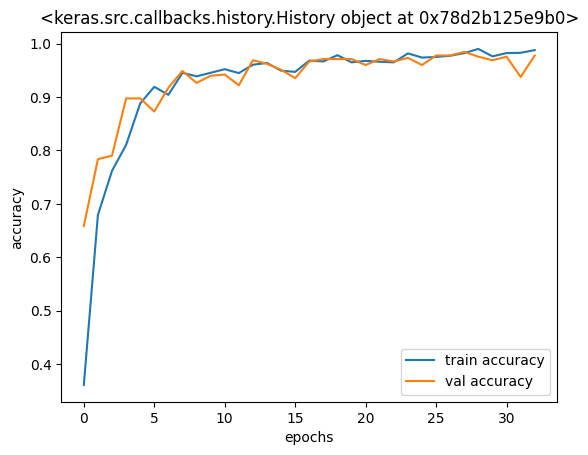

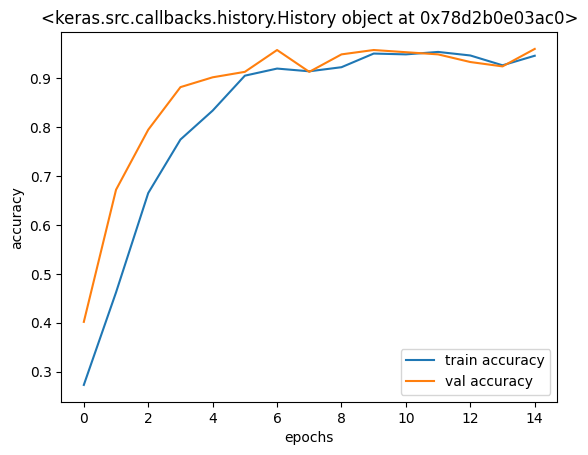

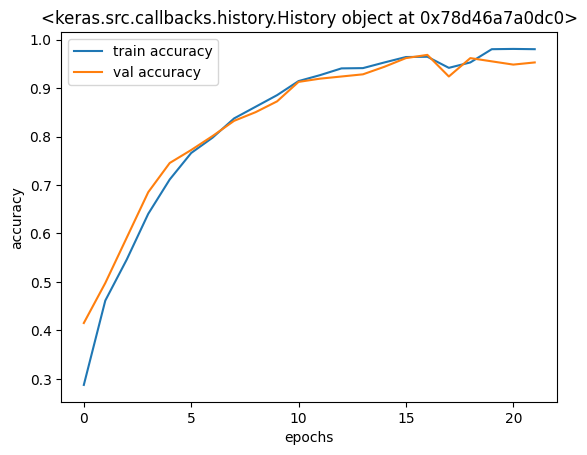

In [97]:
model_history = [lstm_256_teacher_history, lstm_128_teacher_history, gru_history]

for i in range(len(model_history)):

    history = model_history[i]

    # Create a list of epoch numbers based on the length of the accuracy arrays
    epochs = list(range(len(history.history['accuracy'])))

    # Extract training accuracy and validation accuracy from the history object
    acc = history.history['accuracy']           # Training accuracy
    val_acc = history.history['val_accuracy']   # Validation accuracy

    # Plot training and validation accuracy
    plt.plot(epochs, acc, label='train accuracy')
    plt.plot(epochs, val_acc, label='val accuracy')

    # Set the labels for the x and y axes
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    # Set the title of the plot
    plt.title(f"{model_history[i]}")
    # Show legend and plot
    plt.legend()
    plt.show()


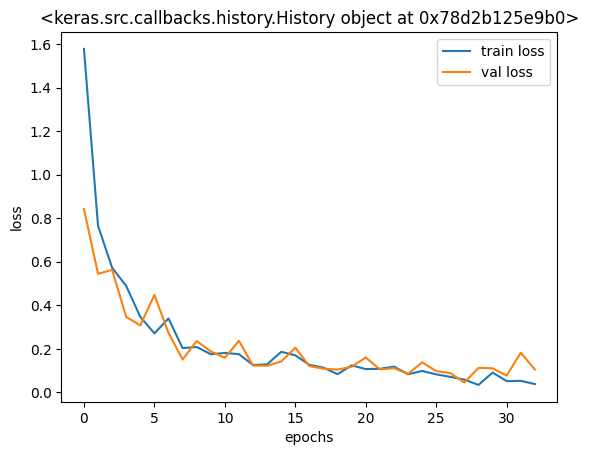

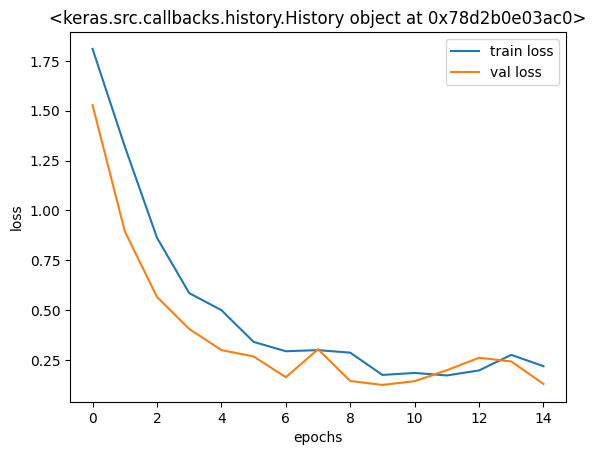

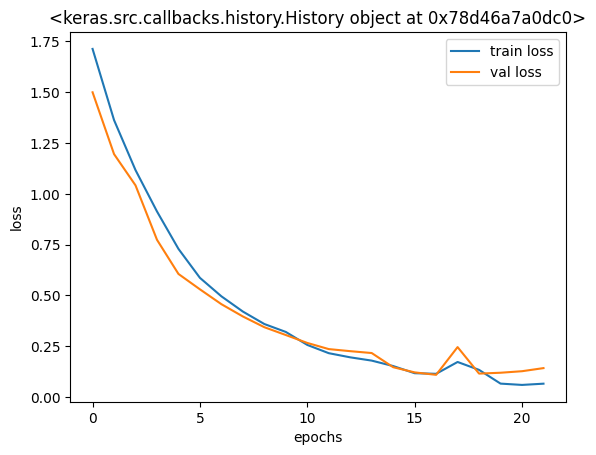

In [98]:
for i in range(len(model_history)):

    history = model_history[i]

    epochs = list(range(len(history.history['accuracy'])))

    # Extract the loss and validation loss from the history object
    loss = history.history['loss']          # Training Loss
    val_loss = history.history['val_loss']  # Validation Loss

    plt.plot(epochs, loss, label='train loss')   # Plot training loss
    plt.plot(epochs, val_loss, label='val loss') # Plot validation loss

    # Set the labels for the x and y axes
    plt.xlabel('epochs')
    plt.ylabel('loss')

    # Set the title of the plot
    plt.title(f"{model_history[i]}")
    plt.legend() # Legend to differentiate between training and validation accuracy
    plt.show()

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

<h2><b>Prediction</b></h2>

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
<Sequential name=sequential_1, built=True>


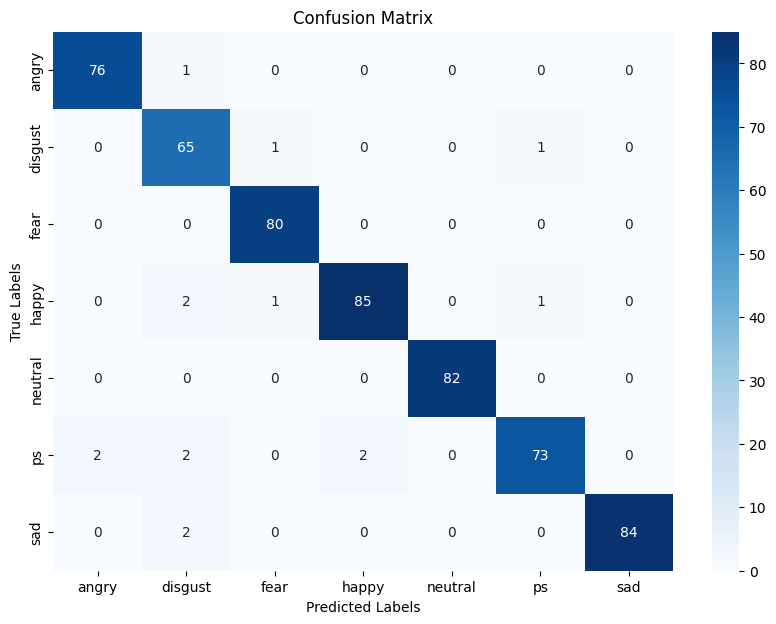

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
<Sequential name=sequential_2, built=True>


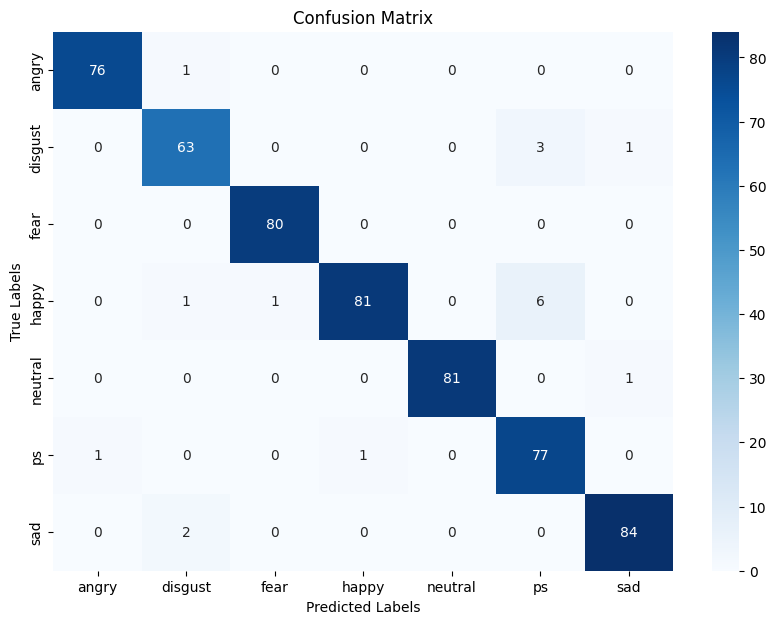

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
<Sequential name=sequential_3, built=True>


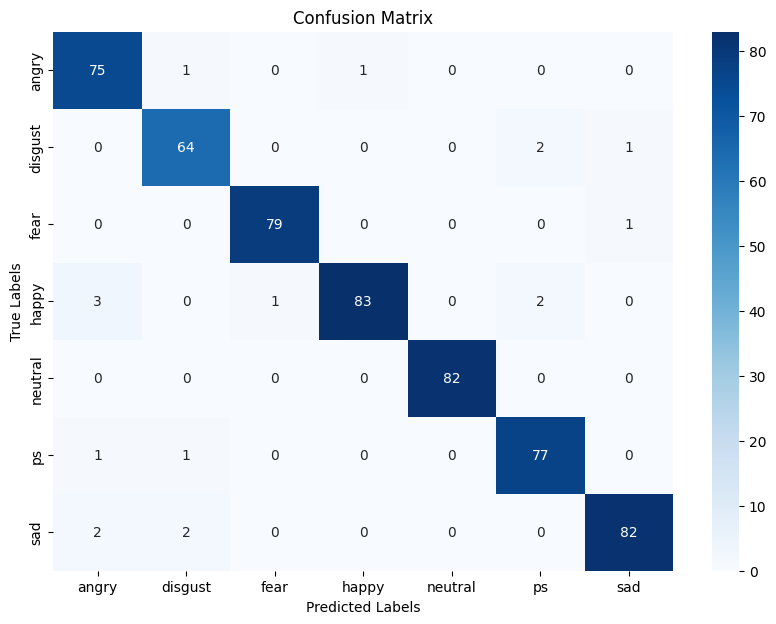

In [100]:
models = [lstm_256_teacher_model, lstm_128_teacher_model, gru_model]
for i in range(len(models)):

    model = models[i]

    # Generate predictions for the test dataset using the teacher model
    y_pred = model.predict(X_test)

    # Convert predicted probabilities to class labels by taking the index of the maximum probability
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert one-hot encoded true labels to class labels by taking the index of the maximum value in each row
    y_test_classes = np.argmax(y_test, axis=1)

    print(f"{model}")
    # Print the first 100 predicted and actual labels for comparison
    # print(f"Predicted labels: {y_pred_classes[:100]}")
    # print(f"Actual labels: {y_test_classes[:100]}")


    # Compute the confusion matrix using the true labels and predicted labels
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Get the class labels from the OneHotEncoder used during training
    labels = enc.categories_[0]

    # Set up the figure for the confusion matrix
    plt.figure(figsize=(10, 7))

    # Create a heatmap to visualize the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Set the labels for the x and y axes
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix') # Set the title of the plot
    plt.show()



In [101]:
!mkdir Predict

In [102]:
# Initialize an empty dictionary to store label and corresponding one-hot encoding
label_to_onehot = {}

# Get the unique labels from the encoder
unique_labels = enc.categories_[0]

# Loop to store the label and its corresponding one-hot encoding in the dictionary
for i, label in enumerate(unique_labels):
    encoding = [0] * len(unique_labels)  # Initialize a zero array
    encoding[i] = 1  # Set 1 at the position corresponding to the current label
    label_to_onehot[label] = encoding  # Store in the dictionary

# Now you have a dictionary with labels as keys and one-hot encodings as values
label_to_onehot

{'angry': [1, 0, 0, 0, 0, 0, 0],
 'disgust': [0, 1, 0, 0, 0, 0, 0],
 'fear': [0, 0, 1, 0, 0, 0, 0],
 'happy': [0, 0, 0, 1, 0, 0, 0],
 'neutral': [0, 0, 0, 0, 1, 0, 0],
 'ps': [0, 0, 0, 0, 0, 1, 0],
 'sad': [0, 0, 0, 0, 0, 0, 1]}

In [116]:
import librosa
import numpy as np
from keras.models import load_model

# List of emotions corresponding to the output classes in your model
emotions = ['fear', 'ps', 'sad', 'angry', 'disgust', 'happy', 'neutral']

# Function to extract MFCCs from an audio file
def extract_mfcc(filename):
    # Load the audio file with librosa
    # 'duration' specifies the length of the audio clip to load (in seconds)
    # 'offset' specifies the start time to load the audio
    y, sr = librosa.load(filename, duration=3, offset=0.5)

    # Extract MFCC features from the audio data
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=60).T, axis=0)
    return mfcc

In [117]:
# audio_file = '/content/TESS Toronto emotional speech set data/YAF_angry/YAF_back_angry.wav'
# audio_mfcc = extract_mfcc(audio_file)
# # audio_mfcc

In [118]:
# audio_mfcc = np.expand_dims(audio_mfcc, axis=0)  # Add batch dimension
# # audio_mfcc

In [119]:
# audio_mfcc = np.expand_dims(audio_mfcc, axis=-1)  # Add channel dimension
# # audio_mfcc

In [120]:
# audio_pred = teacher_model.predict(audio_mfcc)
# audio_pred_classes = np.argmax(audio_pred, axis=1)
# print(f"Predicted labels: {audio_pred_classes}")

# for label in label_to_onehot:
#     if label_to_onehot[label][audio_pred_classes[0]] == 1:
#         print(f"Predicted emotion: {label}")


In [121]:
predict_dir = r'/content/Predict'
predict_paths = []

for dirname, _, filenames in os.walk(predict_dir):
    for filename in filenames:
        predict_paths.append(os.path.join(dirname, filename))
predict_paths

['/content/Predict/YAF_back_angry.wav']

In [122]:
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
for audio_file in predict_paths:
    audio_mfcc = extract_mfcc(audio_file)
    audio_mfcc = np.expand_dims(audio_mfcc, axis=0)  # Add batch dimension
    audio_mfcc = np.expand_dims(audio_mfcc, axis=-1)  # Add channel dimension

    audio_pred = lstm_256_teacher_model.predict(audio_mfcc)[0]
    # audio_pred_classes = np.argmax(audio_pred, axis=1)
    # print(f"Predicted labels: {audio_pred_classes}")

    n = 3
    top_n_indices = np.argsort(audio_pred)[-n:][::-1]

    for label in label_to_onehot:
        for i in range(n):
            if label_to_onehot[label][top_n_indices[i]] == 1:
                print(f"Predicted emotion: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted emotion: angry
Predicted emotion: happy
Predicted emotion: ps


<h3> <b> Transformer Model Prediction</b> <h3>

In [123]:
predict_folder = r'/content/Predict'

In [124]:
# Function to load and preprocess an audio file
def preprocess_audio(file_path, processor, max_length=32000):
    # Load the audio file
    speech, sr = librosa.load(file_path, sr=16000)

    # Pad or truncate the speech to the required length
    if len(speech) > max_length:
        speech = speech[:max_length]
    else:
        speech = np.pad(speech, (0, max_length - len(speech)), 'constant')

    # Preprocess the audio
    inputs = processor(
        speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=max_length
    )
    return inputs.input_values.squeeze()

In [125]:
# Function to predict the top three labels of audio files in a folder
def predict_top_three_labels(folder_path, model, processor, label_map):
    # Get all audio files in the folder
    audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

    if not audio_files:
        print("No audio files found in the folder!")
        return

    predictions = []

    for audio_file in audio_files:
        file_path = os.path.join(folder_path, audio_file)
        try:
            # Preprocess the audio
            input_values = preprocess_audio(file_path, processor).unsqueeze(0).cuda()

            # Perform inference
            with torch.no_grad():
                outputs = model(input_values)
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=-1).squeeze()

            # Get the top 3 predicted classes and their probabilities
            top3_indices = torch.topk(probabilities, k=3).indices.tolist()
            top3_probs = torch.topk(probabilities, k=3).values.tolist()
            top3_labels = [inverse_label_map[idx] for idx in top3_indices]

            # Combine results
            top3_predictions = list(zip(top3_labels, top3_probs))
            predictions.append((audio_file, top3_predictions))
        except Exception as e:
            print(f"Error processing file {audio_file}: {e}")

    return predictions

In [126]:
# Predict top-3 labels for audio files in the Predict folder
predictions = predict_top_three_labels(predict_folder, tf_model, processor, inverse_label_map)

In [127]:
# Display predictions
if predictions:
    print("Predictions:")
    for audio_file, top3 in predictions:
        print(f"{audio_file}:")
        for label, prob in top3:
            print(f"    {label}: {prob:.4f}")
        print()

Predictions:
YAF_back_angry.wav:
    angry: 0.8750
    neutral: 0.0263
    ps: 0.0224



In [128]:
import os
import shutil

# Specify the folder path
folder_path = '/content/Predict'

# Remove all files from the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directory and its contents
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')
